<a href="https://colab.research.google.com/github/elhamsh93/object-detection/blob/main/YOLO_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !pip install super-gradients
# %%capture
!pip install super-gradients==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

[2023-06-11 14:50:02] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-11 14:50:11] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-11 14:50:11] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-11 14:50:11] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-11 14:50:11] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


# Download UAV Dataset


In [2]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size, 
            unit='iB', 
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')
        
download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    'hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

  0%|          | 0.00/200M [00:00<?, ?iB/s]

In [3]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

Extracted all


In [2]:
ROOT_DIR = 'hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [3]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [4]:
# Global parameters.
EPOCHS = 50
BATCH_SIZE = 16
WORKERS = 8

# Visualize Ground Truth Images


In [5]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [6]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 
     # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image, 
            p1, p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3.5, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [8]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

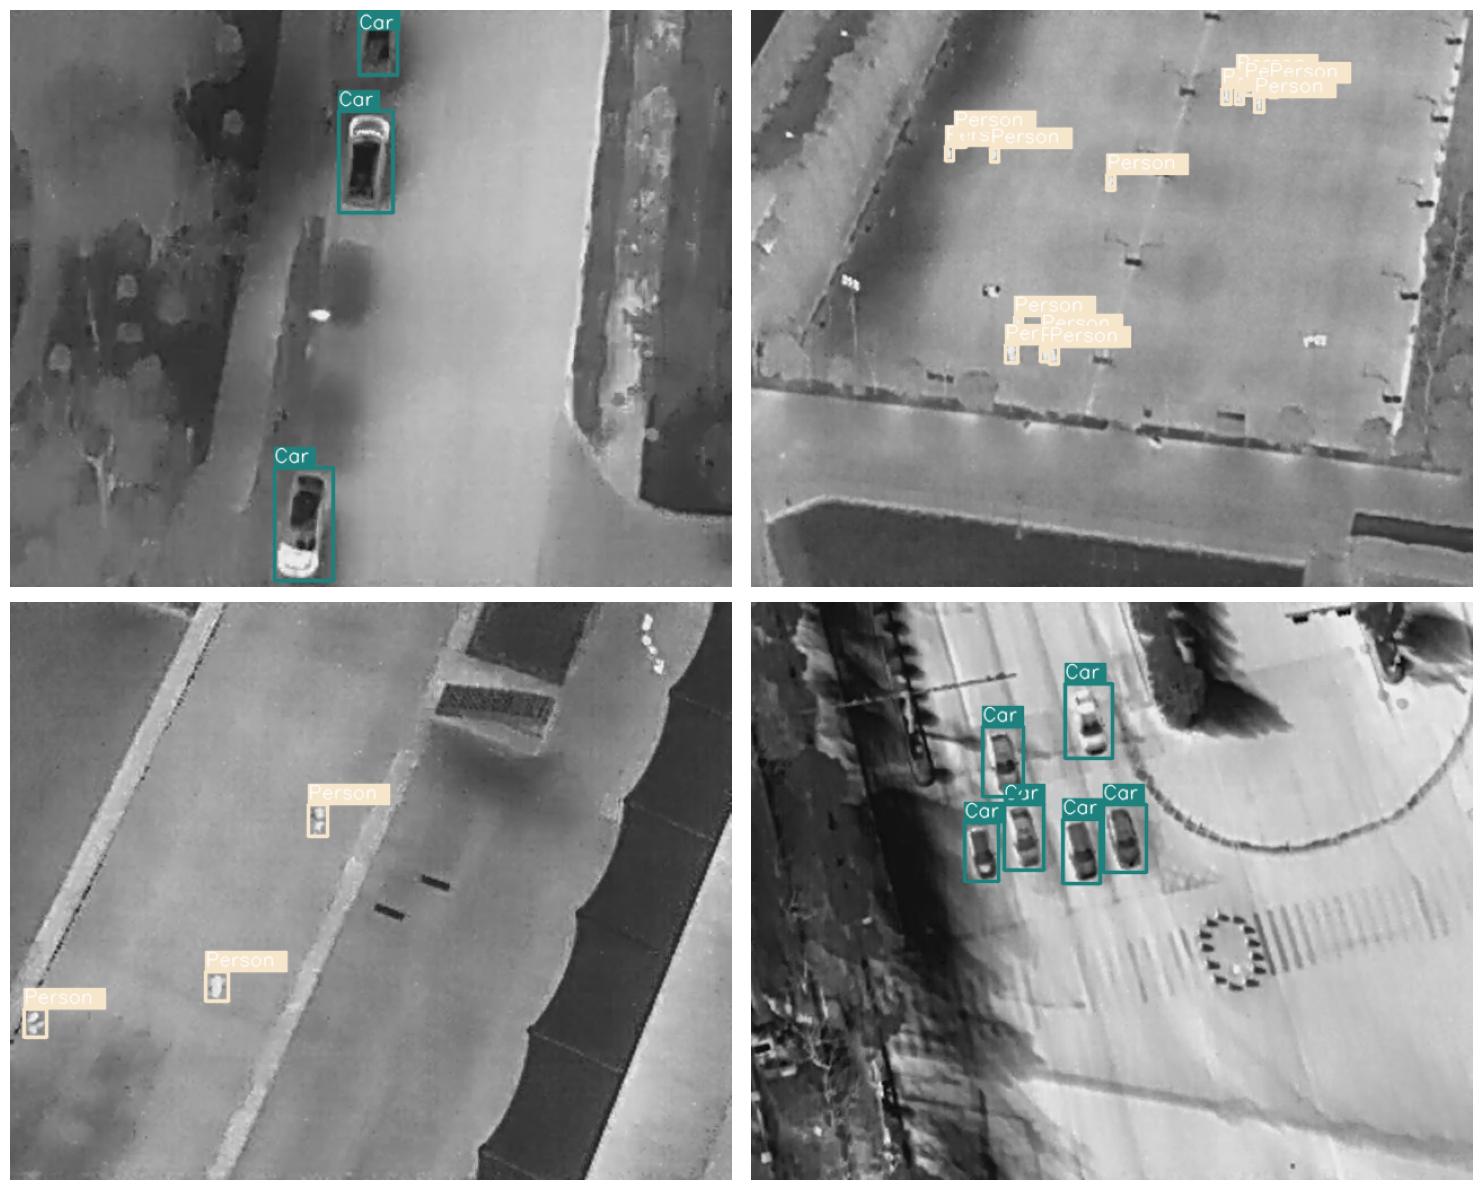

In [9]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

# Data Preparation


In [10]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 2008/2008 [00:04<00:00, 465.38it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Caching annotations: 100%|██████████| 287/287 [00:00<00:00, 450.42it/s]


# Transforms and Augmentations


In [11]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [12]:
train_data.dataset.transforms[0]


DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114)

In [13]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [14]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1), 'input_dim': [640, 640], 'max_targets': 120, 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name

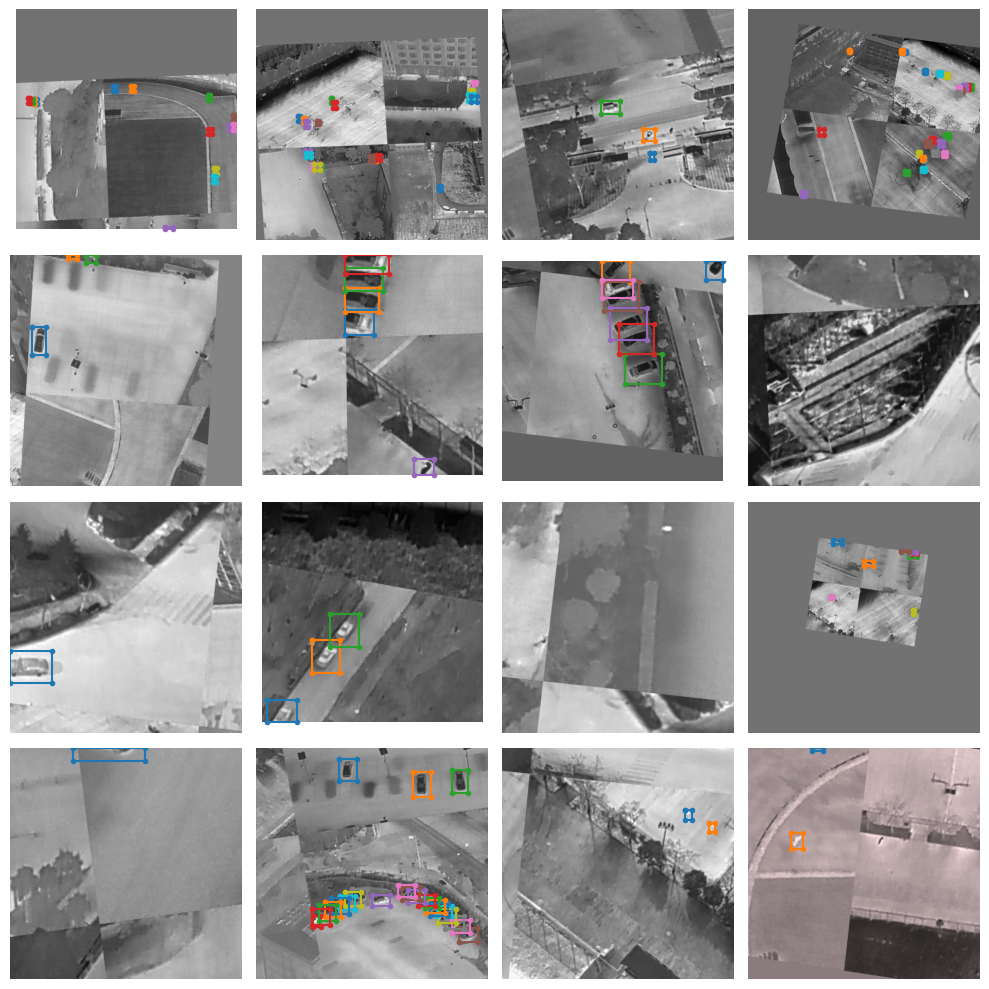

In [15]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

# Prepare Model and Training Parameters


In [16]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
     "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [17]:
models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]

In [18]:
CHECKPOINT_DIR = 'checkpoints'


# Model Training


In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )

    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2023-06-11 14:52:05] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
[2023-06-11 14:52:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-11 14:52:12] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/yolo_nas_s/console_Jun11_14_52_12.txt


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-06-11 14:52:28] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size

SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.5894
│   ├── Ppyoloeloss/loss_cls = 2.1602
│   ├── Ppyoloeloss/loss_dfl = 1.1382
│   └── Ppyoloeloss/loss_iou = 0.344
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0082
    ├── Map@0.50:0.95 = 0.0032
    ├── Ppyoloeloss/loss = 3.4681
    ├── Ppyoloeloss/loss_cls = 2.2249
    ├── Ppyoloeloss/loss_dfl = 0.9889
    ├── Ppyoloeloss/loss_iou = 0.2995
    ├── Precision@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-06-11 14:54:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 14:54:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.003232174552977085
Validation epoch 1: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.1206
│   │   ├── Best until now = 3.5894 (↘ -1.4688)
│   │   └── Epoch N-1      = 3.5894 (↘ -1.4688)
│   ├── Ppyoloeloss/loss_cls = 1.0911
│   │   ├── Best until now = 2.1602 (↘ -1.0691)
│   │   └── Epoch N-1      = 2.1602 (↘ -1.0691)
│   ├── Ppyoloeloss/loss_dfl = 0.8209
│   │   ├── Best until now = 1.1382 (↘ -0.3173)
│   │   └── Epoch N-1      = 1.1382 (↘ -0.3173)
│   └── Ppyoloeloss/loss_iou = 0.2476
│       ├── Best until now = 0.344  (↘ -0.0964)
│       └── Epoch N-1      = 0.344  (↘ -0.0964)
└── Validation
    ├── F1@0.50 = 0.0722
    │   ├── Best until now = 0.0    (↗ 0.0722)
    │   └── Epoch N-1      = 0.0    (↗ 0.0722)
    ├── F1@0.50:0.95 = 0.0394
    │   ├── Best until now = 0.0    (↗ 0.0394)
    │   └── Epoch N-1      = 0.0    (↗ 0.0394)
    ├── Map@0.50 = 0.3637
    │   ├── Best until now = 0.0082 (↗ 0.3555)
    │   └── Epoch N-1      = 0.0082 (↗ 0.3555)
    ├── Map@0.50:0.95 = 0.1663
    │   ├── Best until now 

[2023-06-11 14:57:27] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 14:57:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1662556678056717
Validation epoch 2: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9377
│   │   ├── Best until now = 2.1206 (↘ -0.1829)
│   │   └── Epoch N-1      = 2.1206 (↘ -0.1829)
│   ├── Ppyoloeloss/loss_cls = 0.953
│   │   ├── Best until now = 1.0911 (↘ -0.1381)
│   │   └── Epoch N-1      = 1.0911 (↘ -0.1381)
│   ├── Ppyoloeloss/loss_dfl = 0.81
│   │   ├── Best until now = 0.8209 (↘ -0.0109)
│   │   └── Epoch N-1      = 0.8209 (↘ -0.0109)
│   └── Ppyoloeloss/loss_iou = 0.2319
│       ├── Best until now = 0.2476 (↘ -0.0157)
│       └── Epoch N-1      = 0.2476 (↘ -0.0157)
└── Validation
    ├── F1@0.50 = 0.0646
    │   ├── Best until now = 0.0722 (↘ -0.0076)
    │   └── Epoch N-1      = 0.0722 (↘ -0.0076)
    ├── F1@0.50:0.95 = 0.0345
    │   ├── Best until now = 0.0394 (↘ -0.0049)
    │   └── Epoch N-1      = 0.0394 (↘ -0.0049)
    ├── Map@0.50 = 0.3951
    │   ├── Best until now = 0.3637 (↗ 0.0314)
    │   └── Epoch N-1      = 0.3637 (↗ 0.0314)
    ├── Map@0.50:0.95 = 0.1955
    │   ├── Best until now

[2023-06-11 14:59:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 14:59:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1954672634601593
Validation epoch 3: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.9314
│   │   ├── Best until now = 1.9377 (↘ -0.0063)
│   │   └── Epoch N-1      = 1.9377 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_cls = 0.9472
│   │   ├── Best until now = 0.953  (↘ -0.0058)
│   │   └── Epoch N-1      = 0.953  (↘ -0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.8143
│   │   ├── Best until now = 0.81   (↗ 0.0043)
│   │   └── Epoch N-1      = 0.81   (↗ 0.0043)
│   └── Ppyoloeloss/loss_iou = 0.2308
│       ├── Best until now = 0.2319 (↘ -0.0011)
│       └── Epoch N-1      = 0.2319 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.0724
    │   ├── Best until now = 0.0722 (↗ 0.0002)
    │   └── Epoch N-1      = 0.0646 (↗ 0.0078)
    ├── F1@0.50:0.95 = 0.0387
    │   ├── Best until now = 0.0394 (↘ -0.0007)
    │   └── Epoch N-1      = 0.0345 (↗ 0.0043)
    ├── Map@0.50 = 0.3772
    │   ├── Best until now = 0.3951 (↘ -0.0179)
    │   └── Epoch N-1      = 0.3951 (↘ -0.0179)
    ├── Map@0.50:0.95 = 0.1919
    │   ├── Best until now

Validation epoch 4: 100%|██████████| 18/18 [00:20<00:00,  1.11s/it]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.8465
│   │   ├── Best until now = 1.9314 (↘ -0.0848)
│   │   └── Epoch N-1      = 1.9314 (↘ -0.0848)
│   ├── Ppyoloeloss/loss_cls = 0.8939
│   │   ├── Best until now = 0.9472 (↘ -0.0533)
│   │   └── Epoch N-1      = 0.9472 (↘ -0.0533)
│   ├── Ppyoloeloss/loss_dfl = 0.7961
│   │   ├── Best until now = 0.81   (↘ -0.0138)
│   │   └── Epoch N-1      = 0.8143 (↘ -0.0181)
│   └── Ppyoloeloss/loss_iou = 0.2218
│       ├── Best until now = 0.2308 (↘ -0.009)
│       └── Epoch N-1      = 0.2308 (↘ -0.009)
└── Validation
    ├── F1@0.50 = 0.0758
    │   ├── Best until now = 0.0724 (↗ 0.0034)
    │   └── Epoch N-1      = 0.0724 (↗ 0.0034)
    ├── F1@0.50:0.95 = 0.0427
    │   ├── Best until now = 0.0394 (↗ 0.0032)
    │   └── Epoch N-1      = 0.0387 (↗ 0.0039)
    ├── Map@0.50 = 0.4594
    │   ├── Best until now = 0.3951 (↗ 0.0644)
    │   └── Epoch N-1      = 0.3772 (↗ 0.0823)
    ├── Map@0.50:0.95 = 0.2203
    │   ├── Best until now = 

[2023-06-11 15:05:28] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:05:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22030045092105865
Validation epoch 5: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.812
│   │   ├── Best until now = 1.8465 (↘ -0.0345)
│   │   └── Epoch N-1      = 1.8465 (↘ -0.0345)
│   ├── Ppyoloeloss/loss_cls = 0.8812
│   │   ├── Best until now = 0.8939 (↘ -0.0126)
│   │   └── Epoch N-1      = 0.8939 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.779
│   │   ├── Best until now = 0.7961 (↘ -0.0172)
│   │   └── Epoch N-1      = 0.7961 (↘ -0.0172)
│   └── Ppyoloeloss/loss_iou = 0.2165
│       ├── Best until now = 0.2218 (↘ -0.0053)
│       └── Epoch N-1      = 0.2218 (↘ -0.0053)
└── Validation
    ├── F1@0.50 = 0.1503
    │   ├── Best until now = 0.0758 (↗ 0.0745)
    │   └── Epoch N-1      = 0.0758 (↗ 0.0745)
    ├── F1@0.50:0.95 = 0.0827
    │   ├── Best until now = 0.0427 (↗ 0.04)
    │   └── Epoch N-1      = 0.0427 (↗ 0.04)
    ├── Map@0.50 = 0.4502
    │   ├── Best until now = 0.4594 (↘ -0.0092)
    │   └── Epoch N-1      = 0.4594 (↘ -0.0092)
    ├── Map@0.50:0.95 = 0.2222
    │   ├── Best until now = 0.

[2023-06-11 15:08:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:08:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22221359610557556
Validation epoch 6: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.7868
│   │   ├── Best until now = 1.812  (↘ -0.0252)
│   │   └── Epoch N-1      = 1.812  (↘ -0.0252)
│   ├── Ppyoloeloss/loss_cls = 0.8598
│   │   ├── Best until now = 0.8812 (↘ -0.0214)
│   │   └── Epoch N-1      = 0.8812 (↘ -0.0214)
│   ├── Ppyoloeloss/loss_dfl = 0.7712
│   │   ├── Best until now = 0.779  (↘ -0.0077)
│   │   └── Epoch N-1      = 0.779  (↘ -0.0077)
│   └── Ppyoloeloss/loss_iou = 0.2166
│       ├── Best until now = 0.2165 (↗ 0.0)
│       └── Epoch N-1      = 0.2165 (↗ 0.0)
└── Validation
    ├── F1@0.50 = 0.0922
    │   ├── Best until now = 0.1503 (↘ -0.0581)
    │   └── Epoch N-1      = 0.1503 (↘ -0.0581)
    ├── F1@0.50:0.95 = 0.0504
    │   ├── Best until now = 0.0827 (↘ -0.0323)
    │   └── Epoch N-1      = 0.0827 (↘ -0.0323)
    ├── Map@0.50 = 0.4893
    │   ├── Best until now = 0.4594 (↗ 0.0299)
    │   └── Epoch N-1      = 0.4502 (↗ 0.0391)
    ├── Map@0.50:0.95 = 0.2274
    │   ├── Best until now = 0.

[2023-06-11 15:11:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:11:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2274196743965149
Validation epoch 7: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.7792
│   │   ├── Best until now = 1.7868 (↘ -0.0076)
│   │   └── Epoch N-1      = 1.7868 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_cls = 0.8522
│   │   ├── Best until now = 0.8598 (↘ -0.0076)
│   │   └── Epoch N-1      = 0.8598 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.776
│   │   ├── Best until now = 0.7712 (↗ 0.0048)
│   │   └── Epoch N-1      = 0.7712 (↗ 0.0048)
│   └── Ppyoloeloss/loss_iou = 0.2156
│       ├── Best until now = 0.2165 (↘ -0.0009)
│       └── Epoch N-1      = 0.2166 (↘ -0.001)
└── Validation
    ├── F1@0.50 = 0.1023
    │   ├── Best until now = 0.1503 (↘ -0.0479)
    │   └── Epoch N-1      = 0.0922 (↗ 0.0101)
    ├── F1@0.50:0.95 = 0.0604
    │   ├── Best until now = 0.0827 (↘ -0.0223)
    │   └── Epoch N-1      = 0.0504 (↗ 0.01)
    ├── Map@0.50 = 0.4805
    │   ├── Best until now = 0.4893 (↘ -0.0088)
    │   └── Epoch N-1      = 0.4893 (↘ -0.0088)
    ├── Map@0.50:0.95 = 0.2467
    │   ├── Best until now = 

[2023-06-11 15:14:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:14:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24665683507919312
Validation epoch 8: 100%|██████████| 18/18 [00:23<00:00,  1.32s/it]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7789
│   │   ├── Best until now = 1.7792 (↘ -0.0004)
│   │   └── Epoch N-1      = 1.7792 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_cls = 0.8655
│   │   ├── Best until now = 0.8522 (↗ 0.0133)
│   │   └── Epoch N-1      = 0.8522 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_dfl = 0.764
│   │   ├── Best until now = 0.7712 (↘ -0.0072)
│   │   └── Epoch N-1      = 0.776  (↘ -0.012)
│   └── Ppyoloeloss/loss_iou = 0.2125
│       ├── Best until now = 0.2156 (↘ -0.0031)
│       └── Epoch N-1      = 0.2156 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.1012
    │   ├── Best until now = 0.1503 (↘ -0.049)
    │   └── Epoch N-1      = 0.1023 (↘ -0.0011)
    ├── F1@0.50:0.95 = 0.0567
    │   ├── Best until now = 0.0827 (↘ -0.0259)
    │   └── Epoch N-1      = 0.0604 (↘ -0.0036)
    ├── Map@0.50 = 0.5494
    │   ├── Best until now = 0.4893 (↗ 0.0601)
    │   └── Epoch N-1      = 0.4805 (↗ 0.069)
    ├── Map@0.50:0.95 = 0.2814
    │   ├── Best until now = 

[2023-06-11 15:17:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:17:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2814163565635681
Validation epoch 9: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.7436
│   │   ├── Best until now = 1.7789 (↘ -0.0353)
│   │   └── Epoch N-1      = 1.7789 (↘ -0.0353)
│   ├── Ppyoloeloss/loss_cls = 0.8372
│   │   ├── Best until now = 0.8522 (↘ -0.0151)
│   │   └── Epoch N-1      = 0.8655 (↘ -0.0283)
│   ├── Ppyoloeloss/loss_dfl = 0.7523
│   │   ├── Best until now = 0.764  (↘ -0.0117)
│   │   └── Epoch N-1      = 0.764  (↘ -0.0117)
│   └── Ppyoloeloss/loss_iou = 0.2121
│       ├── Best until now = 0.2125 (↘ -0.0004)
│       └── Epoch N-1      = 0.2125 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.117
    │   ├── Best until now = 0.1503 (↘ -0.0333)
    │   └── Epoch N-1      = 0.1012 (↗ 0.0157)
    ├── F1@0.50:0.95 = 0.0677
    │   ├── Best until now = 0.0827 (↘ -0.015)
    │   └── Epoch N-1      = 0.0567 (↗ 0.011)
    ├── Map@0.50 = 0.5725
    │   ├── Best until now = 0.5494 (↗ 0.0231)
    │   └── Epoch N-1      = 0.5494 (↗ 0.0231)
    ├── Map@0.50:0.95 = 0.3072
    │   ├── Best until now =

[2023-06-11 15:20:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:20:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.30718690156936646
Validation epoch 10: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.7469
│   │   ├── Best until now = 1.7436 (↗ 0.0033)
│   │   └── Epoch N-1      = 1.7436 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_cls = 0.8328
│   │   ├── Best until now = 0.8372 (↘ -0.0044)
│   │   └── Epoch N-1      = 0.8372 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.759
│   │   ├── Best until now = 0.7523 (↗ 0.0067)
│   │   └── Epoch N-1      = 0.7523 (↗ 0.0067)
│   └── Ppyoloeloss/loss_iou = 0.2138
│       ├── Best until now = 0.2121 (↗ 0.0017)
│       └── Epoch N-1      = 0.2121 (↗ 0.0017)
└── Validation
    ├── F1@0.50 = 0.0899
    │   ├── Best until now = 0.1503 (↘ -0.0604)
    │   └── Epoch N-1      = 0.117  (↘ -0.0271)
    ├── F1@0.50:0.95 = 0.0517
    │   ├── Best until now = 0.0827 (↘ -0.0309)
    │   └── Epoch N-1      = 0.0677 (↘ -0.016)
    ├── Map@0.50 = 0.5941
    │   ├── Best until now = 0.5725 (↗ 0.0216)
    │   └── Epoch N-1      = 0.5725 (↗ 0.0216)
    ├── Map@0.50:0.95 = 0.2974
    │   ├── Best until now = 0

Validation epoch 11: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.7402
│   │   ├── Best until now = 1.7436 (↘ -0.0034)
│   │   └── Epoch N-1      = 1.7469 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_cls = 0.8344
│   │   ├── Best until now = 0.8328 (↗ 0.0016)
│   │   └── Epoch N-1      = 0.8328 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.7569
│   │   ├── Best until now = 0.7523 (↗ 0.0045)
│   │   └── Epoch N-1      = 0.759  (↘ -0.0021)
│   └── Ppyoloeloss/loss_iou = 0.211
│       ├── Best until now = 0.2121 (↘ -0.0011)
│       └── Epoch N-1      = 0.2138 (↘ -0.0029)
└── Validation
    ├── F1@0.50 = 0.1829
    │   ├── Best until now = 0.1503 (↗ 0.0326)
    │   └── Epoch N-1      = 0.0899 (↗ 0.093)
    ├── F1@0.50:0.95 = 0.1045
    │   ├── Best until now = 0.0827 (↗ 0.0219)
    │   └── Epoch N-1      = 0.0517 (↗ 0.0528)
    ├── Map@0.50 = 0.5427
    │   ├── Best until now = 0.5941 (↘ -0.0514)
    │   └── Epoch N-1      = 0.5941 (↘ -0.0514)
    ├── Map@0.50:0.95 = 0.2809
    │   ├── Best until now = 

Validation epoch 12: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.7292
│   │   ├── Best until now = 1.7402 (↘ -0.011)
│   │   └── Epoch N-1      = 1.7402 (↘ -0.011)
│   ├── Ppyoloeloss/loss_cls = 0.8298
│   │   ├── Best until now = 0.8328 (↘ -0.003)
│   │   └── Epoch N-1      = 0.8344 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.7521
│   │   ├── Best until now = 0.7523 (↘ -0.0003)
│   │   └── Epoch N-1      = 0.7569 (↘ -0.0048)
│   └── Ppyoloeloss/loss_iou = 0.2093
│       ├── Best until now = 0.211  (↘ -0.0016)
│       └── Epoch N-1      = 0.211  (↘ -0.0016)
└── Validation
    ├── F1@0.50 = 0.1598
    │   ├── Best until now = 0.1829 (↘ -0.0231)
    │   └── Epoch N-1      = 0.1829 (↘ -0.0231)
    ├── F1@0.50:0.95 = 0.0885
    │   ├── Best until now = 0.1045 (↘ -0.016)
    │   └── Epoch N-1      = 0.1045 (↘ -0.016)
    ├── Map@0.50 = 0.5608
    │   ├── Best until now = 0.5941 (↘ -0.0333)
    │   └── Epoch N-1      = 0.5427 (↗ 0.0181)
    ├── Map@0.50:0.95 = 0.2841
    │   ├── Best until now

Validation epoch 13: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.7231
│   │   ├── Best until now = 1.7292 (↘ -0.0061)
│   │   └── Epoch N-1      = 1.7292 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_cls = 0.8298
│   │   ├── Best until now = 0.8298 (↘ -0.0)
│   │   └── Epoch N-1      = 0.8298 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.7483
│   │   ├── Best until now = 0.7521 (↘ -0.0037)
│   │   └── Epoch N-1      = 0.7521 (↘ -0.0037)
│   └── Ppyoloeloss/loss_iou = 0.2077
│       ├── Best until now = 0.2093 (↘ -0.0017)
│       └── Epoch N-1      = 0.2093 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.1181
    │   ├── Best until now = 0.1829 (↘ -0.0648)
    │   └── Epoch N-1      = 0.1598 (↘ -0.0417)
    ├── F1@0.50:0.95 = 0.0701
    │   ├── Best until now = 0.1045 (↘ -0.0344)
    │   └── Epoch N-1      = 0.0885 (↘ -0.0184)
    ├── Map@0.50 = 0.5788
    │   ├── Best until now = 0.5941 (↘ -0.0153)
    │   └── Epoch N-1      = 0.5608 (↗ 0.018)
    ├── Map@0.50:0.95 = 0.3055
    │   ├── Best until now =

Validation epoch 14: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.718
│   │   ├── Best until now = 1.7231 (↘ -0.0051)
│   │   └── Epoch N-1      = 1.7231 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_cls = 0.8255
│   │   ├── Best until now = 0.8298 (↘ -0.0043)
│   │   └── Epoch N-1      = 0.8298 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.7452
│   │   ├── Best until now = 0.7483 (↘ -0.0031)
│   │   └── Epoch N-1      = 0.7483 (↘ -0.0031)
│   └── Ppyoloeloss/loss_iou = 0.2079
│       ├── Best until now = 0.2077 (↗ 0.0003)
│       └── Epoch N-1      = 0.2077 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.1613
    │   ├── Best until now = 0.1829 (↘ -0.0216)
    │   └── Epoch N-1      = 0.1181 (↗ 0.0431)
    ├── F1@0.50:0.95 = 0.0959
    │   ├── Best until now = 0.1045 (↘ -0.0086)
    │   └── Epoch N-1      = 0.0701 (↗ 0.0257)
    ├── Map@0.50 = 0.5923
    │   ├── Best until now = 0.5941 (↘ -0.0018)
    │   └── Epoch N-1      = 0.5788 (↗ 0.0135)
    ├── Map@0.50:0.95 = 0.2992
    │   ├── Best until now

Validation epoch 15: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.6996
│   │   ├── Best until now = 1.718  (↘ -0.0184)
│   │   └── Epoch N-1      = 1.718  (↘ -0.0184)
│   ├── Ppyoloeloss/loss_cls = 0.8136
│   │   ├── Best until now = 0.8255 (↘ -0.0119)
│   │   └── Epoch N-1      = 0.8255 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.7372
│   │   ├── Best until now = 0.7452 (↘ -0.008)
│   │   └── Epoch N-1      = 0.7452 (↘ -0.008)
│   └── Ppyoloeloss/loss_iou = 0.207
│       ├── Best until now = 0.2077 (↘ -0.0007)
│       └── Epoch N-1      = 0.2079 (↘ -0.001)
└── Validation
    ├── F1@0.50 = 0.1163
    │   ├── Best until now = 0.1829 (↘ -0.0666)
    │   └── Epoch N-1      = 0.1613 (↘ -0.045)
    ├── F1@0.50:0.95 = 0.0665
    │   ├── Best until now = 0.1045 (↘ -0.0381)
    │   └── Epoch N-1      = 0.0959 (↘ -0.0294)
    ├── Map@0.50 = 0.6446
    │   ├── Best until now = 0.5941 (↗ 0.0505)
    │   └── Epoch N-1      = 0.5923 (↗ 0.0524)
    ├── Map@0.50:0.95 = 0.3206
    │   ├── Best until now 

[2023-06-11 15:36:49] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-11 15:36:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3205764889717102
Train epoch 16:  41%|████      | 51/125 [01:05<01:35,  1.29s/it, PPYoloELoss/loss=1.69, PPYoloELoss/loss_cls=0.811, PPYoloELoss/loss_dfl=0.734, PPYoloELoss/loss_iou=0.206, gpu_mem=13.3]
[2023-06-11 15:38:23] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2023-06-11 15:38:23] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2023-06-11 15:38:23] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-06-11 15:38:23] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detaile

  0%|          | 0.00/196M [00:00<?, ?B/s]

[2023-06-11 15:38:28] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_m/console_Jun11_15_38_28.txt


[2023-06-11 15:38:39] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         125        (len(train_loader))
    - Gradient updates per epoch:   125        (len(train_loader) / batch_accumulate)

[2023-06-11 15:38:39] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Train epoch 0:  63%|██████▎   | 79/125 [01:43<00:57,  1.25s/it, PPYoloELoss/loss=3.73, PPYoloELoss/loss_cls=2.28, PPYoloELoss/loss_dfl=1.22, PPYoloELoss/loss_iou=0.336, gpu_mem=13.3]